# Weather Prediction Using LSTM against Linear Regression

## Imports and Setup

In [ ]:
from __future__ import annotations

from pathlib import Path

import numpy as np  # type: ignore
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # type: ignore MinMaxScaler performed more poorly
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # type: ignore
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # type: ignore
from tensorflow import keras
import seaborn as sns
from typing import Any  # noqa: E402

from sklearn.model_selection import train_test_split
import tensorflow as tf
import datetime as dt

RANDOM_SEED: int = 42
tf.random.set_seed(42)
np.random.seed(RANDOM_SEED)

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

TARGET_COLUMN: str = "MeanTemp"  # the column to predict

LOOKBACK: int = 60  # use last x days to predict next day
PATIENCE: int = 10  # early stopping patience
EPOCHS: int = 50  # maximum number of training epochs
BATCH_SIZE: int = 32  # training batch size, reducing batch size improves accuracy but increases training time
DENSE_LAYER: int = 64  # number of neurons in dense layer
ACTIVATION: str = "relu"  # activation function for dense layer
LSTM_UNITS: int = 128
DROPOUT_RATE: float = 0.2  # dropout rate for regularization
TRAIN_RATIO: float = 0.7  # proportion of data to use for training
VALIDATION_RATIO_SPLIT: float = 0.15  # proportion of data to use for validation
STA_WEIGHT: float = 2.0

CATEGORICAL_COLUMNS: list[str] = ["STA"]

STANDARD_FEATURES: list[str] = [
    "STA",  # station identifier, predictions should be grouped per station
    "MaxTemp",
    "MinTemp",
    "MeanTemp",
    "YR",
    "MO",
    "DA",
    # "WindGustSpd",
    # "PGT",
    # added columns
    "DayOfYear",
]

ROBUST_FEATURES: list[str] = ["Snowfall", "Precip"]

ALL_FEATURES = STANDARD_FEATURES + ROBUST_FEATURES

timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")


### Test GPU Availability

In [72]:
if gpus := tf.config.list_physical_devices("GPU"):
    print(f"GPUs available: {gpus}")
    try:
        # Optional: restrict TensorFlow to the first GPU
        tf.config.set_visible_devices(gpus[0], "GPU")
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(f"Using GPU: {logical_gpus}")
    except RuntimeError as e:
        print(f"GPU config error: {e}")
else:
    print("No GPU found, running on CPU.")


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


## Data Pre Processing

### Load and inspect data

In [73]:
DATA_PATH: Path = Path("Summary of Weather.csv")

df_original: pd.DataFrame = pd.read_csv(DATA_PATH)
df: pd.DataFrame = df_original.copy()
df.head()

/tmp/ipykernel_978/3033116151.py:3: DtypeWarning: Columns (0: Snowfall, 1: PoorWeather, 2: SNF, 3: TSHDSBRSGF) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original: pd.DataFrame = pd.read_csv(DATA_PATH)


,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Show basic info

In [74]:
df.info()
df.describe(include="all").T

<class 'pandas.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  str    
 2   Precip       119040 non-null  str    
 3   WindGustSpd  532 non-null     float64
 4   MaxTemp      119040 non-null  float64
 5   MinTemp      119040 non-null  float64
 6   MeanTemp     119040 non-null  float64
 7   Snowfall     117877 non-null  object 
 8   PoorWeather  34237 non-null   object 
 9   YR           119040 non-null  int64  
 10  MO           119040 non-null  int64  
 11  DA           119040 non-null  int64  
 12  PRCP         117108 non-null  str    
 13  DR           533 non-null     float64
 14  SPD          532 non-null     float64
 15  MAX          118566 non-null  float64
 16  MIN          118572 non-null  float64
 17  MEA          118542 non-null  float64
 18  SNF          117877 non-null  objec

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
STA,119040.0,NaN,NaN,NaN,29659.435795,20953.209402,10001.0,11801.0,22508.0,33501.0,82506.0
Date,119040,2192,1945-4-16,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Precip,119040,540,0,64267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WindGustSpd,532.0,NaN,NaN,NaN,37.774534,10.297808,18.52,29.632,37.04,43.059,75.932
MaxTemp,119040.0,NaN,NaN,NaN,27.045111,8.717817,-33.333333,25.555556,29.444444,31.666667,50.0
MinTemp,119040.0,NaN,NaN,NaN,17.789511,8.334572,-38.333333,15.0,21.111111,23.333333,34.444444
MeanTemp,119040.0,NaN,NaN,NaN,22.411631,8.297982,-35.555556,20.555556,25.555556,27.222222,40.0
Snowfall,117877.0,42.0,0.0,86090.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PoorWeather,34237,39,1,25846,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YR,119040.0,NaN,NaN,NaN,43.805284,1.136718,40.0,43.0,44.0,45.0,45.0


### Drop columns with no data

In [75]:
print("Original columns:", df.columns.tolist())
print(len(df.columns))
df = df.dropna(axis=1, how="all")

print("Remaining columns:", df.columns.tolist())
print(len(df.columns))

Original columns: ['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR', 'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH', 'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']
31
Remaining columns: ['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR', 'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'PGT', 'TSHDSBRSGF']
22


### Drop Meaningless Columns

In [76]:
columns_to_drop = ["PoorWeather", "TSHDSBRSGF", "PRCP"]

df = df.drop(columns=columns_to_drop)

### Drop Duplicate Rows

In [77]:
print(f"Duplicated columns: {df.duplicated().sum()}")

if df.duplicated().sum() > 0:
    df = df.drop_duplicates()

int(df.duplicated().sum())

Duplicated columns: 10


0

### Feature Selection and Processing

In [78]:
df_model: pd.DataFrame = df.copy()

# Handle 'T' in precipitation-like columns if they exist
for col in ["Precip", "PRCP"]:
    if col in df_model.columns:
        if df_model[col].dtype in ("str", "object"):
            df_model[col] = df_model[col].replace("T", 0.0)
        # Cast to float
        df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# Convert any remaining object columns that look numeric
for col in df_model.columns:
    if df_model[col].dtype == "object":
        # Try to coerce to numeric, keep non-numeric as NaN
        df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# Parse date and sort
df_model["Date"] = pd.to_datetime(df_model["Date"])

# add day of year feature for seasonality
df_model["DayOfYear"] = df_model["Date"].dt.dayofyear  # type: ignore

df_model = df_model.sort_values("Date").reset_index(drop=True)

# Keep only needed columns + Date for reference
columns_to_use: list[str] = ["Date"] + ALL_FEATURES
df_model = df_model[columns_to_use].copy()

# Drop rows with any missing selected feature values
df_model = df_model.dropna(subset=ALL_FEATURES).reset_index(drop=True)
df_model.head(5)

,Date,STA,MaxTemp,MinTemp,MeanTemp,MO,DayOfYear,Snowfall,Precip
0,1940-01-01,22504,26.666667,17.222222,22.222222,1,1,0.0,2.286
1,1940-01-01,10701,28.333333,22.222222,25.555556,1,1,0.0,7.620
2,1940-01-01,22508,23.333333,17.222222,20.000000,1,1,0.0,0.254
3,1940-01-02,10701,28.888889,23.333333,26.111111,1,2,0.0,15.240
4,1940-01-02,22508,23.333333,16.111111,19.444444,1,2,0.0,10.160


## Shared Code to Calculate Score and Model Accuracy

In [79]:
def plot_predictions(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    title: str = "Actual vs predicted MeanTemp",
    n_points: int = 300,
) -> None:
    """
    Plot actual vs predicted time series.

    Parameters
    ----------
    y_true : np.ndarray
        True target values in original units.
    y_pred : np.ndarray
        Predicted target values in original units.
    title : str
        Title of the plot.
    n_points : int
        Number of last points to plot for readability.
    """
    n = len(y_true)
    start: int = max(0, n - n_points)

    plt.figure(figsize=(12, 4))
    plt.plot(range(start, n), y_true[start:], label="Actual")
    plt.plot(range(start, n), y_pred[start:], label="Predicted")
    plt.xlabel("Time index (relative)")
    plt.ylabel("MeanTemp")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    return mse, rmse, mae, r2


## Linear Regression Baseline

### Train

In [80]:
df_clean_linear = df_model.copy().dropna(subset=[TARGET_COLUMN]).reset_index(drop=True)

target_candidates = [c for c in df.columns if c in [TARGET_COLUMN]]
target_col = target_candidates[0]

numeric_cols = df_clean_linear.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]

X_lin = df_clean_linear[numeric_cols]
y_lin = df_clean_linear[target_col]

# --- Ensure no NaNs before splitting: impute with column means ---
X_lin = X_lin.replace([np.inf, -np.inf], np.nan)  # just in case
X_lin = X_lin.fillna(X_lin.mean())

test_size = 0.2

X_train_lin, X_test_lin, y_train_lin, y_lin_test = train_test_split(
    X_lin, y_lin, test_size=test_size, random_state=RANDOM_SEED
)

X_test_lin.head()

,STA,MaxTemp,MinTemp,MO,DayOfYear,Snowfall,Precip
99100,50403,31.666667,22.222222,6,166,0.0,0.000
31724,30001,30.000000,21.666667,10,274,0.0,13.716
66331,33303,32.777778,22.222222,8,243,0.0,0.000
6367,16405,3.888889,-6.666667,4,107,0.0,0.000
111312,34113,21.111111,12.222222,10,288,0.0,0.000


### Run

In [81]:
# Train model
lin_reg = LinearRegression()
lin_reg.fit(X_train_lin, y_train_lin)

# Predictions
y_train_pred = lin_reg.predict(X_train_lin)
y_test_pred = lin_reg.predict(X_test_lin)


### Validate Model

In [82]:
print("=== Train metrics ===")
train_mse, train_rmse, train_mae, train_r2 = regression_metrics(
    y_train_lin, y_train_pred
)

print("\n=== Test metrics ===")
test_mse, test_rmse, test_mae, test_r2 = regression_metrics(y_lin_test, y_test_pred)


=== Train metrics ===
MSE : 0.2654
RMSE: 0.5152
MAE : 0.1659
R²  : 0.9959

=== Test metrics ===
MSE : 0.2497
RMSE: 0.4997
MAE : 0.1661
R²  : 0.9962


### Plot Predictions Linear Regression

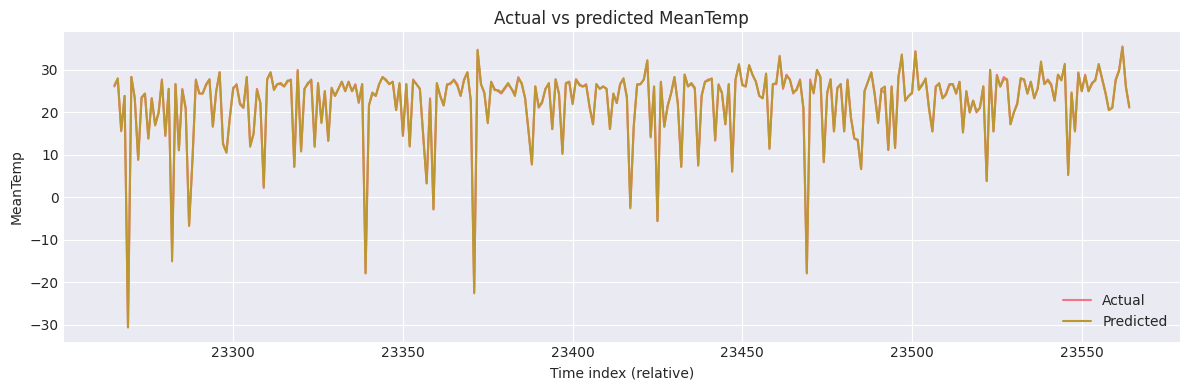

In [83]:
plot_predictions(y_lin_test.values, y_test_pred, n_points=300)

## LSTM Analysis Naive

### Define Sequence Logic

In [84]:
def create_sequences(
    data: np.ndarray, target_index: int, lookback: int = 60
) -> tuple[np.ndarray, np.ndarray]:
    """
    Create (X, y) sequences for LSTM from multivariate time series.

    Parameters
    ----------
    data : np.ndarray
        Time-series data of shape (n_samples, n_features).
    target_index : int
        Index of the feature column to be predicted.
    lookback : int
        Number of past time steps used as input.

    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        X of shape (n_sequences, lookback, n_features),
        y of shape (n_sequences,).
    """
    X_list: list[np.ndarray] = []
    y_list: list[float] = []

    for i in range(lookback, len(data)):
        X_list.append(data[i - lookback : i])
        y_list.append(data[i, target_index])

    X: np.ndarray = np.array(X_list)
    y: np.ndarray = np.array(y_list)

    return X, y


### Sequencing

In [85]:
# scaler: MinMaxScaler = MinMaxScaler(feature_range=(0, 1)) # performs worse than standard scaler
scaler_lstm_1: Any = MinMaxScaler(feature_range=(0, 1))  # to use in LSTM RNN model
# standard_scaler: Any = MinMaxScaler()  # to use in LSTM RNN model

# Extract feature values
features: np.ndarray = df_model[ALL_FEATURES].values

scaled_features: np.ndarray = scaler_lstm_1.fit_transform(features)

target_index: int = ALL_FEATURES.index(TARGET_COLUMN)

X_all, y_all = create_sequences(
    data=scaled_features, target_index=target_index, lookback=LOOKBACK
)

X_all.shape, y_all.shape


((117763, 60, 8), (117763,))

### Train

In [86]:
def train_val_test_split(
    X: np.ndarray, y: np.ndarray, train_ratio: float = 0.7, val_ratio: float = 0.15
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split time-series data into train, validation, and test partitions
    preserving temporal order.

    Parameters
    ----------
    X : np.ndarray
        Input sequences of shape (n, lookback, n_features).
    y : np.ndarray
        Targets of shape (n,).
    train_ratio : float
        Fraction of samples for training.
    val_ratio : float
        Fraction of samples for validation.

    Returns
    -------
    tuple of arrays
        X_train, y_train, X_val, y_val, X_test, y_test.
    """
    n_samples: int = len(X)
    train_end: int = int(n_samples * train_ratio)
    val_end: int = int(n_samples * (train_ratio + val_ratio))

    X_train = X_all[:train_end]
    y_train = y_all[:train_end]

    X_val = X_all[train_end:val_end]
    y_val = y_all[train_end:val_end]

    X_test = X_all[val_end:]
    y_test = y_all[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(
    X_all, y_all, train_ratio=TRAIN_RATIO, val_ratio=VALIDATION_RATIO_SPLIT
)

X_train.shape, X_val.shape, X_test.shape


((82434, 60, 8), (17664, 60, 8), (17665, 60, 8))

### Build Model

In [87]:
def build_lstm_model(
    input_shape: tuple[int, int],
    lstm_units: int = 128,
    dropout_rate: float = 0.5,
) -> Sequential:
    """
    Build a simple LSTM regression model in Keras.

    Parameters
    ----------
    input_shape : tuple[int, int]
        Shape (lookback, n_features) for the input.
    lstm_units : int
        Number of LSTM units.
    dropout_rate : float
        Dropout rate after the LSTM layer.

    Returns
    -------
    Sequential
        Compiled Keras model.
    """
    # input sequence is 60 days or how long the LOOKBACK is
    model = Sequential()
    # 1. LSTM layer 256 memory cells
    model.add(LSTM(lstm_units, input_shape=input_shape))
    # 2. Dropout for regularization
    model.add(Dropout(dropout_rate))
    # Dense (fully connected) hidden layer
    model.add(Dense(DENSE_LAYER, activation=ACTIVATION))
    # Regression output layer
    model.add(Dense(1))  # regression output

    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"],
    )
    return model


input_shape: tuple[int, int] = (X_train.shape[1], X_train.shape[2])
model: Sequential = build_lstm_model(
    input_shape=input_shape, lstm_units=LSTM_UNITS, dropout_rate=DROPOUT_RATE
)
model.summary()


/mnt/c/dev/mary/ml-mid-assessment-linux/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 256)            │       271,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,873 (1.10 MB)

 Trainable params: 287,873 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

### Train

In [88]:
early_stop: EarlyStopping = EarlyStopping(
    monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=1
)

model_checkpoint: ModelCheckpoint = ModelCheckpoint(
    "models/best_lstm_model_station_all_naive.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)

history: keras.callbacks.History = model.fit(
    X_train,
    y_train,
    # validation_data=(X_val, y_val),
    validation_split=VALIDATION_RATIO_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, model_checkpoint],
    verbose=1,
)


Epoch 1/50
2189/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165 - mae: 0.0862
Epoch 1: val_loss improved from None to 0.01377, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 1: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - loss: 0.0131 - mae: 0.0784 - val_loss: 0.0138 - val_mae: 0.0770
Epoch 2/50
2188/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0118 - mae: 0.0731
Epoch 2: val_loss improved from 0.01377 to 0.01281, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 2: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0117 - mae: 0.0730 - val_loss: 0.0128 - val_mae: 0.0755
Epoch 3/50
2189/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0116 - mae: 0.0718
Epoch 3: val_loss did not improve from 0.01281
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0115 - mae: 0.0721 - val_loss: 0.0129 - val_mae: 0.0755
Epoch 4/50
2189/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0115 - mae: 0.0715
Epoch 4: val_loss improved from 0.01281 to 0.01262, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 4: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0115 - mae: 0.0718 - val_loss: 0.0126 - val_mae: 0.0754
Epoch 5/50
2189/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0115 - mae: 0.0714
Epoch 5: val_loss improved from 0.01262 to 0.01242, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 5: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 0.0115 - mae: 0.0716 - val_loss: 0.0124 - val_mae: 0.0754
Epoch 6/50
2154/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0115 - mae: 0.0713
Epoch 6: val_loss improved from 0.01242 to 0.01239, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 6: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0115 - mae: 0.0716 - val_loss: 0.0124 - val_mae: 0.0754
Epoch 7/50
2185/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0115 - mae: 0.0713
Epoch 7: val_loss improved from 0.01239 to 0.01223, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 7: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 0.0114 - mae: 0.0716 - val_loss: 0.0122 - val_mae: 0.0755
Epoch 8/50
2189/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0115 - mae: 0.0713
Epoch 8: val_loss improved from 0.01223 to 0.01199, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 8: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0114 - mae: 0.0716 - val_loss: 0.0120 - val_mae: 0.0754
Epoch 9/50
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114 - mae: 0.0713
Epoch 9: val_loss improved from 0.01199 to 0.01185, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 9: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 0.0114 - mae: 0.0716 - val_loss: 0.0119 - val_mae: 0.0754
Epoch 10/50
2189/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114 - mae: 0.0713
Epoch 10: val_loss did not improve from 0.01185
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 0.0113 - mae: 0.0716 - val_loss: 0.0119 - val_mae: 0.0754
Epoch 11/50
2187/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114 - mae: 0.0713
Epoch 11: val_loss did not improve from 0.01185
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.0113 - mae: 0.0716 - val_loss: 0.0119 - val_mae: 0.0753
Epoch 12/50
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113 - mae: 0.0713
Epoch 12: val_loss did not improve from 0.01185
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0113 - mae: 0.0716 - val_loss: 0.0119 - val_mae: 0.0754
Epoch 13/50
2186/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113 - mae: 


Epoch 13: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.0113 - mae: 0.0715 - val_loss: 0.0118 - val_mae: 0.0754
Epoch 14/50
2186/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113 - mae: 0.0713
Epoch 14: val_loss did not improve from 0.01176
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.0113 - mae: 0.0715 - val_loss: 0.0119 - val_mae: 0.0755
Epoch 15/50
2187/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113 - mae: 0.0713
Epoch 15: val_loss did not improve from 0.01176
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0113 - mae: 0.0715 - val_loss: 0.0119 - val_mae: 0.0752
Epoch 16/50
2186/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113 - mae: 0.0712
Epoch 16: val_loss did not improve from 0.01176
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.0112 - mae: 0.0714 - val_loss: 0.0118 - val_mae: 0.0753
Epoch 17/50
2188/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113 - mae:


Epoch 23: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0112 - mae: 0.0713 - val_loss: 0.0117 - val_mae: 0.0756
Epoch 24/50
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0711
Epoch 24: val_loss did not improve from 0.01171
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0112 - mae: 0.0713 - val_loss: 0.0118 - val_mae: 0.0755
Epoch 25/50
2188/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0711
Epoch 25: val_loss improved from 0.01171 to 0.01171, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 25: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0112 - mae: 0.0713 - val_loss: 0.0117 - val_mae: 0.0756
Epoch 26/50
2186/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0710
Epoch 26: val_loss improved from 0.01171 to 0.01170, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 26: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0112 - mae: 0.0712 - val_loss: 0.0117 - val_mae: 0.0757
Epoch 27/50
2186/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112 - mae: 0.0710
Epoch 27: val_loss improved from 0.01170 to 0.01166, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 27: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0112 - mae: 0.0713 - val_loss: 0.0117 - val_mae: 0.0758
Epoch 28/50
2187/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0710
Epoch 28: val_loss improved from 0.01166 to 0.01163, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 28: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0112 - mae: 0.0712 - val_loss: 0.0116 - val_mae: 0.0757
Epoch 29/50
2185/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112 - mae: 0.0709
Epoch 29: val_loss did not improve from 0.01163
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0111 - mae: 0.0712 - val_loss: 0.0117 - val_mae: 0.0757
Epoch 30/50
2184/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0710
Epoch 30: val_loss improved from 0.01163 to 0.01159, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 30: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0111 - mae: 0.0712 - val_loss: 0.0116 - val_mae: 0.0759
Epoch 31/50
2188/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0709
Epoch 31: val_loss did not improve from 0.01159
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0111 - mae: 0.0712 - val_loss: 0.0116 - val_mae: 0.0759
Epoch 32/50
2185/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0709
Epoch 32: val_loss did not improve from 0.01159
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0111 - mae: 0.0712 - val_loss: 0.0117 - val_mae: 0.0756
Epoch 33/50
2186/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0709
Epoch 33: val_loss improved from 0.01159 to 0.01156, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 33: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0111 - mae: 0.0711 - val_loss: 0.0116 - val_mae: 0.0759
Epoch 34/50
2189/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0710
Epoch 34: val_loss did not improve from 0.01156
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0111 - mae: 0.0711 - val_loss: 0.0116 - val_mae: 0.0758
Epoch 35/50
2188/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - mae: 0.0709
Epoch 35: val_loss improved from 0.01156 to 0.01154, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 35: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0111 - mae: 0.0712 - val_loss: 0.0115 - val_mae: 0.0760
Epoch 36/50
2187/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0709
Epoch 36: val_loss did not improve from 0.01154
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0111 - mae: 0.0712 - val_loss: 0.0116 - val_mae: 0.0758
Epoch 37/50
2186/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0709
Epoch 37: val_loss did not improve from 0.01154
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0111 - mae: 0.0711 - val_loss: 0.0116 - val_mae: 0.0758
Epoch 38/50
2189/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - mae: 0.0709
Epoch 38: val_loss did not improve from 0.01154
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0111 - mae: 0.0711 - val_loss: 0.0116 - val_mae: 0.0758
Epoch 39/50
2185/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0710



Epoch 39: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0111 - mae: 0.0711 - val_loss: 0.0115 - val_mae: 0.0760
Epoch 40/50
2186/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0709
Epoch 40: val_loss did not improve from 0.01154
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0111 - mae: 0.0711 - val_loss: 0.0116 - val_mae: 0.0757
Epoch 41/50
2186/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0709
Epoch 41: val_loss improved from 0.01154 to 0.01152, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 41: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0111 - mae: 0.0711 - val_loss: 0.0115 - val_mae: 0.0761
Epoch 42/50
2188/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0709
Epoch 42: val_loss did not improve from 0.01152
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0111 - mae: 0.0711 - val_loss: 0.0116 - val_mae: 0.0759
Epoch 43/50
2186/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0709
Epoch 43: val_loss did not improve from 0.01152
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0111 - mae: 0.0711 - val_loss: 0.0117 - val_mae: 0.0758
Epoch 44/50
2186/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0709
Epoch 44: val_loss improved from 0.01152 to 0.01152, saving model to models/best_lstm_model_station_all_naive.h5



Epoch 44: finished saving model to models/best_lstm_model_station_all_naive.h5
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0111 - mae: 0.0711 - val_loss: 0.0115 - val_mae: 0.0761
Epoch 45/50
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - mae: 0.0709
Epoch 45: val_loss did not improve from 0.01152
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0111 - mae: 0.0711 - val_loss: 0.0116 - val_mae: 0.0759
Epoch 46/50
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - mae: 0.0708
Epoch 46: val_loss did not improve from 0.01152
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0111 - mae: 0.0711 - val_loss: 0.0116 - val_mae: 0.0760
Epoch 47/50
2189/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0708
Epoch 47: val_loss did not improve from 0.01152
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0111 - mae: 0.0710 - val_loss: 0.0116 - val_mae: 0.0759
Epoch 48/50
2186/2190 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.070

### Visualize Training Health

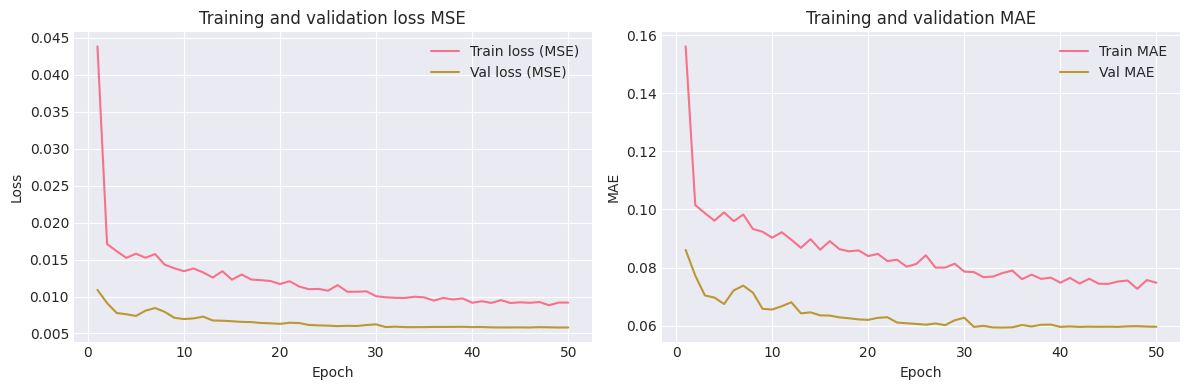

In [99]:
def plot_training_history(history) -> None:
    """
    Plot training and validation loss and MAE over epochs.
    """
    history_dict = history.history
    epochs = range(1, len(history_dict["loss"]) + 1)

    _fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(epochs, history_dict["loss"], label="Train loss (MSE)")
    axes[0].plot(epochs, history_dict["val_loss"], label="Val loss (MSE)")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training and validation loss MSE")
    axes[0].legend()

    axes[1].plot(epochs, history_dict["mae"], label="Train MAE")
    axes[1].plot(epochs, history_dict["val_mae"], label="Val MAE")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("MAE")
    axes[1].set_title("Training and validation MAE")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


plot_training_history(history)


### Validate Model

In [100]:
y_pred_test_scaled: np.ndarray = model.predict(X_test)


# inverse tranform target column to validate and interpret predictions
def inverse_transform_target(
    scaled_target: np.ndarray,
    scaler: Any,
    target_index: int,
) -> np.ndarray:
    """
    Inverse-transform a single target column that was part of a Scaler fit
    on multiple features.

    Parameters
    ----------
    scaled_target : np.ndarray
        Predicted or true target values in scaled space, shape (n_samples, 1) or (n_samples,).
    scaler : Any
        Fitted scaler on the full feature matrix.
    target_index : int
        Index of the target column in the original feature matrix.

    Returns
    -------
    np.ndarray
        Target values in original units, shape (n_samples,).
    """
    scaled_target = np.asarray(scaled_target).reshape(-1, 1)
    n_features: int = scaler.n_features_in_

    # Create dummy zeros for all features, then replace target column
    dummy_scaled = np.zeros((len(scaled_target), n_features))
    dummy_scaled[:, target_index] = scaled_target[:, 0]

    inv_full = scaler.inverse_transform(dummy_scaled)
    return inv_full[:, target_index]


y_test_inv: np.ndarray = inverse_transform_target(y_test, scaler_lstm_1, target_index)
y_pred_test_inv: np.ndarray = inverse_transform_target(
    y_pred_test_scaled, scaler_lstm_1, target_index
)

print("\n=== Test metrics ===")
test_mse, test_rmse, test_mae, test_r2 = regression_metrics(y_test_inv, y_pred_test_inv)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

=== Test metrics ===
MSE : 33.5236
RMSE: 5.7900
MAE : 4.4621
R²  : 0.6775


### Predictions vs Actuals

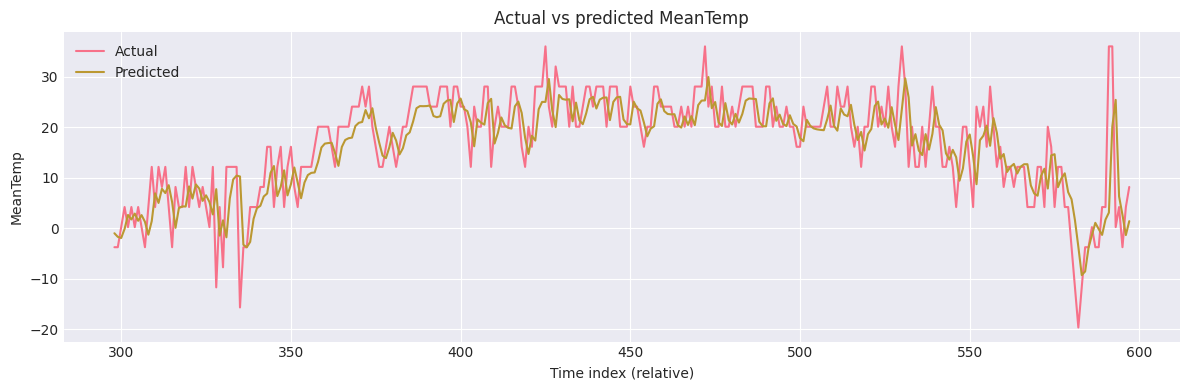

In [101]:
plot_predictions(y_test_inv, y_pred_test_inv, n_points=300)

### Residual analysis

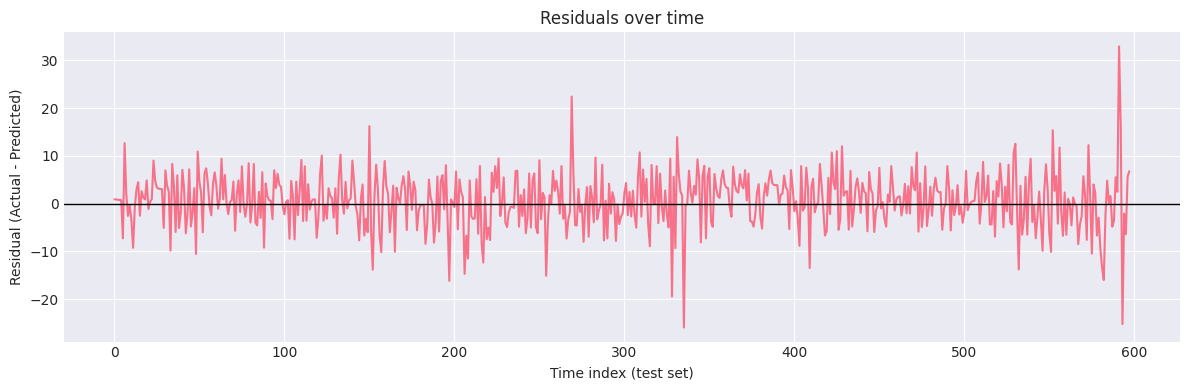

In [102]:
residuals: np.ndarray = y_test_inv - y_pred_test_inv

plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Time index (test set)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals over time")
plt.tight_layout()
plt.show()


## LSTM Enhanced By Station Model

### Station Selection

In [103]:
df = df_original.copy() # copy data to apply different pre-processing engine


def select_station_data(
    df: pd.DataFrame, station_id: int | None = None
) -> tuple[pd.DataFrame, int | None]:
    """
    Select data for a specific station or use the station with most records.

    Args:
        df: Input DataFrame with STA column
        station_id: Specific station ID to select (None = auto-select largest)

    Returns:
        Tuple of (filtered DataFrame, selected station ID)
    """
    if station_id is None:
        # Select station with most records, future iterations will combine all stations
        station_counts: pd.Series = df["STA"].value_counts()
        station_id = station_counts.index[0]
        print(
            f"Auto-selected Station {station_id} (largest dataset: {station_counts.iloc[0]} records)"
        )
    else:
        print("Selected Station {station_id}")

    df_station: pd.DataFrame = df[df["STA"] == station_id].copy()
    print(f"Station {station_id} data shape: {df_station.shape}")

    return df_station, station_id


def preprocess_data(
    df: pd.DataFrame, temperature_column: str = "MeanTemp"
) -> pd.DataFrame:
    """
    Preprocess weather data for a specific station.

    Args:
        df: Input DataFrame (should be station-specific)
        temperature_column: Name of the temperature column to use for prediction

    Returns:
        Preprocessed DataFrame
    """
    df_processed: pd.DataFrame = df.copy()

    # Convert Date column to datetime
    if "Date" in df_processed.columns:
        df_processed["Date"] = pd.to_datetime(df_processed["Date"], errors="coerce")
        df_processed = df_processed.sort_values(by="Date")
        df_processed = df_processed.reset_index(drop=True)

    # Handle missing values in temperature column
    if temperature_column in df_processed.columns:
        # Forward fill then backward fill for temperature as dataset needs continuous values
        df_processed[temperature_column] = (
            df_processed[temperature_column].ffill().bfill()
        )

        # Remove any remaining NaN values
        df_processed = df_processed.dropna(subset=[temperature_column])

    print("Processed data shape: {df_processed.shape}")

    return df_processed

# select station with most data (hack)
df_station: pd.DataFrame
selected_station: int
df_station, selected_station = select_station_data(df, station_id=None) # type: ignore

# process data using selected target independent feature column
df_processed: pd.DataFrame = preprocess_data(df_station, temperature_column=TARGET_COLUMN)
df_processed.head()

Auto-selected Station 22508 (largest dataset: 2192 records)
Station 22508 data shape: (2192, 31)
Processed data shape: {df_processed.shape}


,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,22508,1940-01-01,0.254,NaN,23.333333,17.222222,20.000000,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22508,1940-01-02,10.16,NaN,23.333333,16.111111,19.444444,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22508,1940-01-03,T,NaN,23.888889,15.555556,20.000000,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22508,1940-01-04,2.286,NaN,23.888889,18.333333,21.111111,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22508,1940-01-05,0.254,NaN,22.222222,15.000000,18.333333,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Sequencing

In [104]:
def create_sequences(
    data: np.ndarray, lookback: int = 60
) -> tuple[np.ndarray, np.ndarray]:
    """
    Create sequences for LSTM training.

    Args:
        data: Input data array (scaled)
        lookback: Number of time steps to look back

    Returns:
        Tuple of (X, y) arrays for training
    """
    X: list[np.ndarray] = []
    y: list[float] = []

    for i in range(lookback, len(data)):
        X.append(data[i - lookback : i, 0])
        y.append(data[i, 0])

    X_array: np.ndarray = np.array(X)
    y_array: np.ndarray = np.array(y)

    # Reshape X for LSTM [samples, time steps, features]
    X_array = np.reshape(X_array, (X_array.shape[0], X_array.shape[1], 1))

    return X_array, y_array

# Extract temperature data for selected station
temperature_data: np.ndarray = df_processed[TARGET_COLUMN].values.reshape(-1, 1) # type: ignore

print(f"Station {selected_station} - Total data points: {len(temperature_data)}")

# Normalize the data
scaler_lstm_station: MinMaxScaler = MinMaxScaler(feature_range=(0, 1))
temperature_scaled: np.ndarray = scaler_lstm_station.fit_transform(temperature_data)

print("Data normalized.")

# split test / train sets
train_size: int = int(len(temperature_scaled) * TRAIN_RATIO)
train_data: np.ndarray = temperature_scaled[:train_size]
test_data: np.ndarray = temperature_scaled[train_size:]

print(
    f"Training data size: {train_size} ({(train_size / len(temperature_scaled) * 100):.1f}%)"
)
print(
    f"Testing data size: {len(test_data)} ({(len(test_data) / len(temperature_scaled) * 100):.1f}%)"
)

# Create sequences
print(f"Creating sequences with lookback period: {LOOKBACK} days")

X_train: np.ndarray
y_train: np.ndarray
X_train, y_train = create_sequences(train_data, LOOKBACK)

X_test: np.ndarray
y_test: np.ndarray
X_test, y_test = create_sequences(test_data, LOOKBACK)

print(f"Sequences created successfully for Station {selected_station}!")

Station 22508 - Total data points: 2192
Data normalized.
Training data size: 1534 (70.0%)
Testing data size: 658 (30.0%)
Creating sequences with lookback period: 60 days
Sequences created successfully for Station 22508!


### Build Model

In [105]:
def build_lstm_model_per_station(
    input_shape: tuple[int, int],
    lstm_units: list[int] = [50, 50],
    dropout_rate: float = 0.2,
) -> Sequential:
    """
    Build LSTM model for prediction.

    Args:
        input_shape: Shape of input data (time steps, features)
        lstm_units: List of units for each LSTM layer
        dropout_rate: Dropout rate for regularization

    Returns:
        Compiled Keras Sequential model
    """
    model: Sequential = Sequential()

    # First LSTM layer
    model.add(LSTM(units=lstm_units[0], return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # Second LSTM layer
    model.add(LSTM(units=lstm_units[1], return_sequences=False))
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(units=1))

    # Compile model
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

    return model


# build the model against train data
print(f"Building LSTM model for Station {selected_station}...")
model: Sequential = build_lstm_model_per_station(
    input_shape=(X_train.shape[1], 1), lstm_units=[50, 50], dropout_rate=DROPOUT_RATE
)

print("\n📋 Model Architecture:")
print("=" * 70)
model.summary()
print("=" * 70)
print("✅ Model built successfully!")

Building LSTM model for Station 22508...

📋 Model Architecture:


/mnt/c/dev/mary/ml-mid-assessment-linux/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

✅ Model built successfully!


### Train

In [106]:
# save resources if GPU is limited
early_stopping: EarlyStopping = EarlyStopping(
    monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=1
)

# define model checkpoint to save best model and optimize resources
model_checkpoint: ModelCheckpoint = ModelCheckpoint(
    f"models/best_lstm_model_station_{selected_station}_{timestamp}.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)

# train the model for station with most data
print(f"Training the model for Station {selected_station}...")
print("=" * 70)
history: keras.callbacks.History = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_RATIO_SPLIT,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1,
)

print("\n" + "=" * 70)
print("Training completed!")
print(f"Total epochs trained: {len(history.history['loss'])}")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")

Training the model for Station 22508...
Epoch 1/50


38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1426 - mae: 0.3004
Epoch 1: val_loss improved from None to 0.00926, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 1: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0631 - mae: 0.1859 - val_loss: 0.0093 - val_mae: 0.0773
Epoch 2/50
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0178 - mae: 0.1060
Epoch 2: val_loss improved from 0.00926 to 0.00826, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 2: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0173 - mae: 0.1024 - val_loss: 0.0083 - val_mae: 0.0723
Epoch 3/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0167 - mae: 0.1020
Epoch 3: val_loss improved from 0.00826 to 0.00786, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 3: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0165 - mae: 0.1009 - val_loss: 0.0079 - val_mae: 0.0707
Epoch 4/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0160 - mae: 0.0988
Epoch 4: val_loss improved from 0.00786 to 0.00779, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 4: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0163 - mae: 0.0993 - val_loss: 0.0078 - val_mae: 0.0706
Epoch 5/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0149 - mae: 0.0956
Epoch 5: val_loss improved from 0.00779 to 0.00749, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 5: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0159 - mae: 0.0983 - val_loss: 0.0075 - val_mae: 0.0683
Epoch 6/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0141 - mae: 0.0934
Epoch 6: val_loss improved from 0.00749 to 0.00746, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 6: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0145 - mae: 0.0932 - val_loss: 0.0075 - val_mae: 0.0688
Epoch 7/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0145 - mae: 0.0953
Epoch 7: val_loss did not improve from 0.00746
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0149 - mae: 0.0965 - val_loss: 0.0082 - val_mae: 0.0703
Epoch 8/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0140 - mae: 0.0932
Epoch 8: val_loss improved from 0.00746 to 0.00746, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 8: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0141 - mae: 0.0931 - val_loss: 0.0075 - val_mae: 0.0691
Epoch 9/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0148 - mae: 0.0950
Epoch 9: val_loss improved from 0.00746 to 0.00729, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 9: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0149 - mae: 0.0951 - val_loss: 0.0073 - val_mae: 0.0666
Epoch 10/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0151 - mae: 0.0968
Epoch 10: val_loss improved from 0.00729 to 0.00725, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 10: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0147 - mae: 0.0952 - val_loss: 0.0073 - val_mae: 0.0664
Epoch 11/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0149 - mae: 0.0943
Epoch 11: val_loss improved from 0.00725 to 0.00705, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 11: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0147 - mae: 0.0946 - val_loss: 0.0070 - val_mae: 0.0660
Epoch 12/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0137 - mae: 0.0917
Epoch 12: val_loss improved from 0.00705 to 0.00704, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 12: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0138 - mae: 0.0917 - val_loss: 0.0070 - val_mae: 0.0668
Epoch 13/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0142 - mae: 0.0939
Epoch 13: val_loss improved from 0.00704 to 0.00691, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 13: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0138 - mae: 0.0922 - val_loss: 0.0069 - val_mae: 0.0655
Epoch 14/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0125 - mae: 0.0870
Epoch 14: val_loss did not improve from 0.00691
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0130 - mae: 0.0886 - val_loss: 0.0071 - val_mae: 0.0659
Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0140 - mae: 0.0920
Epoch 15: val_loss improved from 0.00691 to 0.00678, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 15: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0135 - mae: 0.0907 - val_loss: 0.0068 - val_mae: 0.0645
Epoch 16/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0129 - mae: 0.0889
Epoch 16: val_loss did not improve from 0.00678
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0127 - mae: 0.0875 - val_loss: 0.0068 - val_mae: 0.0644
Epoch 17/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0127 - mae: 0.0883
Epoch 17: val_loss did not improve from 0.00678
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0128 - mae: 0.0881 - val_loss: 0.0069 - val_mae: 0.0647
Epoch 18/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0126 - mae: 0.0888
Epoch 18: val_loss did not improve from 0.00678
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0126 - mae: 0.0874 - val_loss: 0.0069 - val_mae: 0.0647
Epoch 19/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0123 - mae: 0.0856
Epoch 19: val_lo


Epoch 19: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0120 - mae: 0.0845 - val_loss: 0.0065 - val_mae: 0.0629
Epoch 20/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0128 - mae: 0.0885
Epoch 20: val_loss improved from 0.00652 to 0.00647, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 20: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0124 - mae: 0.0869 - val_loss: 0.0065 - val_mae: 0.0631
Epoch 21/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0128 - mae: 0.0883
Epoch 21: val_loss improved from 0.00647 to 0.00637, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 21: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0122 - mae: 0.0856 - val_loss: 0.0064 - val_mae: 0.0622
Epoch 22/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0118 - mae: 0.0849
Epoch 22: val_loss improved from 0.00637 to 0.00633, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 22: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0118 - mae: 0.0843 - val_loss: 0.0063 - val_mae: 0.0622
Epoch 23/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0119 - mae: 0.0854
Epoch 23: val_loss did not improve from 0.00633
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0120 - mae: 0.0856 - val_loss: 0.0064 - val_mae: 0.0624
Epoch 24/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0120 - mae: 0.0860
Epoch 24: val_loss improved from 0.00633 to 0.00622, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 24: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0119 - mae: 0.0849 - val_loss: 0.0062 - val_mae: 0.0614
Epoch 25/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0116 - mae: 0.0855
Epoch 25: val_loss improved from 0.00622 to 0.00616, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 25: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0115 - mae: 0.0845 - val_loss: 0.0062 - val_mae: 0.0611
Epoch 26/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0111 - mae: 0.0830
Epoch 26: val_loss improved from 0.00616 to 0.00615, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 26: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0111 - mae: 0.0824 - val_loss: 0.0061 - val_mae: 0.0610
Epoch 27/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0119 - mae: 0.0847
Epoch 27: val_loss improved from 0.00615 to 0.00610, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 27: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0121 - mae: 0.0863 - val_loss: 0.0061 - val_mae: 0.0608
Epoch 28/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0103 - mae: 0.0801
Epoch 28: val_loss did not improve from 0.00610
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0105 - mae: 0.0802 - val_loss: 0.0062 - val_mae: 0.0615
Epoch 29/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0114 - mae: 0.0814
Epoch 29: val_loss did not improve from 0.00610
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0111 - mae: 0.0810 - val_loss: 0.0063 - val_mae: 0.0622
Epoch 30/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0108 - mae: 0.0817
Epoch 30: val_loss improved from 0.00610 to 0.00599, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 30: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0108 - mae: 0.0805 - val_loss: 0.0060 - val_mae: 0.0604
Epoch 31/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0107 - mae: 0.0815
Epoch 31: val_loss did not improve from 0.00599
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0105 - mae: 0.0806 - val_loss: 0.0060 - val_mae: 0.0602
Epoch 32/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0106 - mae: 0.0798
Epoch 32: val_loss did not improve from 0.00599
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0106 - mae: 0.0803 - val_loss: 0.0060 - val_mae: 0.0606
Epoch 33/50
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0105 - mae: 0.0799
Epoch 33: val_loss improved from 0.00599 to 0.00598, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 33: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ -0s -4186us/step - loss: 0.0104 - mae: 0.0792 - val_loss: 0.0060 - val_mae: 0.0599
Epoch 34/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0103 - mae: 0.0786
Epoch 34: val_loss improved from 0.00598 to 0.00598, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 34: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0102 - mae: 0.0783 - val_loss: 0.0060 - val_mae: 0.0601
Epoch 35/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0110 - mae: 0.0808
Epoch 35: val_loss improved from 0.00598 to 0.00588, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 35: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0106 - mae: 0.0799 - val_loss: 0.0059 - val_mae: 0.0599
Epoch 36/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0099 - mae: 0.0777
Epoch 36: val_loss did not improve from 0.00588
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0097 - mae: 0.0768 - val_loss: 0.0059 - val_mae: 0.0596
Epoch 37/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0101 - mae: 0.0792
Epoch 37: val_loss did not improve from 0.00588
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0098 - mae: 0.0776 - val_loss: 0.0060 - val_mae: 0.0613
Epoch 38/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0096 - mae: 0.0784
Epoch 38: val_loss improved from 0.00588 to 0.00585, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 38: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0096 - mae: 0.0773 - val_loss: 0.0059 - val_mae: 0.0594
Epoch 39/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0107 - mae: 0.0822
Epoch 39: val_loss improved from 0.00585 to 0.00584, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 39: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0104 - mae: 0.0809 - val_loss: 0.0058 - val_mae: 0.0598
Epoch 40/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0101 - mae: 0.0777
Epoch 40: val_loss did not improve from 0.00584
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0098 - mae: 0.0766 - val_loss: 0.0059 - val_mae: 0.0605
Epoch 41/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0092 - mae: 0.0762
Epoch 41: val_loss improved from 0.00584 to 0.00583, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 41: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0092 - mae: 0.0756 - val_loss: 0.0058 - val_mae: 0.0595
Epoch 42/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0103 - mae: 0.0784
Epoch 42: val_loss improved from 0.00583 to 0.00582, saving model to models/best_lstm_model_station_22508_20260201_233111.h5



Epoch 42: finished saving model to models/best_lstm_model_station_22508_20260201_233111.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0097 - mae: 0.0770 - val_loss: 0.0058 - val_mae: 0.0595
Epoch 43/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0092 - mae: 0.0767
Epoch 43: val_loss did not improve from 0.00582
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0094 - mae: 0.0766 - val_loss: 0.0061 - val_mae: 0.0611
Epoch 44/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0102 - mae: 0.0786
Epoch 44: val_loss did not improve from 0.00582
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0099 - mae: 0.0778 - val_loss: 0.0059 - val_mae: 0.0595
Epoch 45/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0100 - mae: 0.0783
Epoch 45: val_loss did not improve from 0.00582
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0095 - mae: 0.0764 - val_loss: 0.0059 - val_mae: 0.0598
Epoch 46/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0095 - mae: 0.0762
Epoch 46: val_lo

### Predictions

In [107]:
print("Making predictions for Station {selected_station}...")
train_predictions: np.ndarray = model.predict(X_train, verbose=0)
test_predictions: np.ndarray = model.predict(X_test, verbose=0)

print('Completed predictions.')

# Inverse transform predictions to original scale
train_predictions_original: np.ndarray = scaler_lstm_station.inverse_transform(train_predictions)
test_predictions_original: np.ndarray = scaler_lstm_station.inverse_transform(test_predictions)
y_train_original: np.ndarray = scaler_lstm_station.inverse_transform(y_train.reshape(-1, 1))
y_test_original: np.ndarray = scaler_lstm_station.inverse_transform(y_test.reshape(-1, 1))

print('Scaled back original features and values for validation.')

Making predictions for Station {selected_station}...
Completed predictions.
Scaled back original features and values for validation.


### Validate Model

In [108]:
print(f"Test Set Metrics - Station {selected_station}:")
print("=" * 70)
regression_metrics(
    y_train_original, train_predictions_original
)

# Calculate metrics for test set
print(f"Test Set Metrics - Station {selected_station}:")
print("=" * 70)
regression_metrics(
    y_test_original, test_predictions_original
)


Test Set Metrics - Station 22508:
MSE : 0.7756
RMSE: 0.8807
MAE : 0.6751
R²  : 0.7877
Test Set Metrics - Station 22508:
MSE : 0.6546
RMSE: 0.8091
MAE : 0.6217
R²  : 0.6774


(0.6546081405317152,
 np.float64(0.809078575004749),
 0.6216541548210995,
 0.6773725800320589)

### Predictions vs Actuals

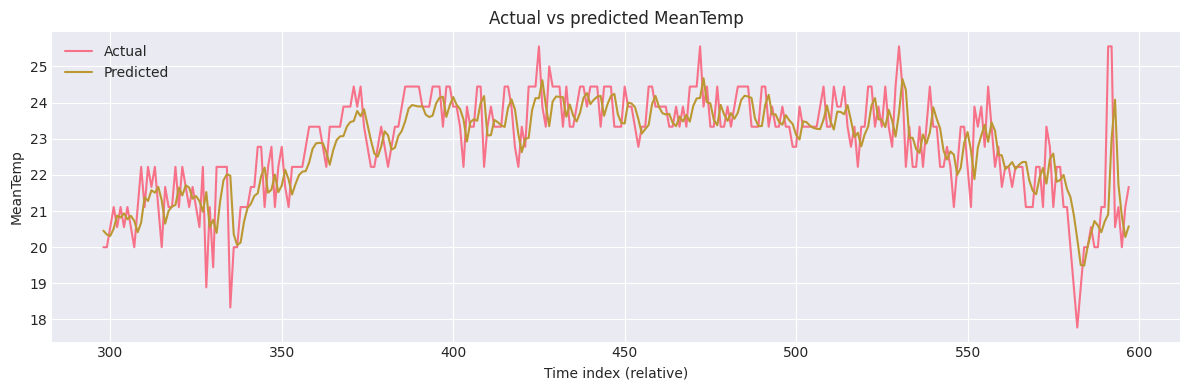

In [109]:
plot_predictions(y_test_original, test_predictions_original, n_points=300)

## LSTM Enhanced MultiVariate

### Processing

In [ ]:
df = df_original.copy()

# Handle 'T' in precipitation-like columns if they exist
for col in ["Precip", "PRCP"]:
    if col in df.columns:
        if df[col].dtype in ("str", "object"):
            df[col] = df[col].replace("T", 0.0)
        # Cast to float
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Convert any remaining object columns that look numeric
for col in df.columns:
    if df[col].dtype == "object":
        # Try to coerce to numeric, keep non-numeric as NaN
        df[col] = pd.to_numeric(df[col], errors="coerce")

# use the following features to train the model for the specific station
potential_features = ['MeanTemp', 'MaxTemp', 'MinTemp', 'Precip', 'Snowfall', "YR", "MO", "DA"]
available_features = [col for col in potential_features if col in df.columns]

# fill missing values
df[available_features] = df[available_features].ffill().bfill()
df = df.dropna(subset=available_features)

### Sequencing

In [ ]:
def create_multivariate_sequences(data: np.ndarray, lookback: int = 60) -> tuple[np.ndarray, np.ndarray]:
    """
    Create sequences for multivariate LSTM training.
    
    Args:
        data: Input data array (scaled) with shape (samples, features)
        lookback: Number of time steps to look back
        
    Returns:
        Tuple of (X, y) arrays where:
        - X shape: (samples, lookback, num_features)
        - y shape: (samples,) - predicting only MeanTemp (first feature)
    """
    X = []
    y = []
    
    for i in range(lookback, len(data)):
        # X contains all features for the lookback period
        X.append(data[i-lookback:i, :])
        # y contains only the target (MeanTemp - first column) for next time step
        y.append(data[i, 0])
    
    X_array = np.array(X)
    y_array = np.array(y)
    
    return X_array, y_array

# Extract feature data
feature_data = df[available_features].values
print(f"Feature data shape: {feature_data.shape} (samples, features)")
print(f"Features used: {available_features}")

# normalize each feature independently
scaler = MinMaxScaler(feature_range=(0, 1))
feature_data_scaled = scaler.fit_transform(feature_data)

# split into test and train sets
train_size = int(len(feature_data_scaled) * TRAIN_RATIO)
train_data = feature_data_scaled[:train_size]
test_data = feature_data_scaled[train_size:]

print(f"Training data size: {train_size} ({train_size/len(feature_data_scaled)*100:.1f}%)")
print(f"Testing data size: {len(test_data)} ({len(test_data)/len(feature_data_scaled)*100:.1f}%)")

# create sequences
print(f"Created sequences for test and train sets with lookback period: {LOOKBACK} days")

X_train, y_train = create_multivariate_sequences(train_data, LOOKBACK)
X_test, y_test = create_multivariate_sequences(test_data, LOOKBACK)


Feature data shape: (119040, 8) (samples, features)
Features used: ['MeanTemp', 'MaxTemp', 'MinTemp', 'Precip', 'Snowfall', 'YR', 'MO', 'DA']
Training data size: 83328 (70.0%)
Testing data size: 35712 (30.0%)
Created sequences for test and train sets with lookback period: 60 days


### Build Model

In [ ]:
def build_multivariate_lstm(input_shape: tuple[int, int], 
                           lstm_units: list[int] = [50, 50],
                           dropout_rate: float = 0.2) -> Sequential:
    """
    Build multivariate LSTM model for prediction.
    
    Args:
        input_shape: Shape of input data (time steps, num_features)
        lstm_units: List of units for each LSTM layer
        dropout_rate: Dropout rate for regularization
        
    Returns:
        Compiled Keras Sequential model
    """
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=lstm_units[0], return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer
    model.add(LSTM(units=lstm_units[1], return_sequences=False))
    model.add(Dropout(dropout_rate))
    
    # Output layer (predicting single value: MeanTemp)
    model.add(Dense(units=1))
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

# Build the model
model = build_multivariate_lstm(
    input_shape=(X_train.shape[1], X_train.shape[2]),  # (time_steps, num_features)
    lstm_units=[50, 50],
    dropout_rate=DROPOUT_RATE
)

print("Model Architecture:")
print("="*70)
model.summary()
print("="*70)

Model Architecture:


/mnt/c/dev/mary/ml-mid-assessment-linux/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 60, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,051 (125.20 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

station_suffix = f"_station_{selected_station}" if selected_station else ""
model_checkpoint = ModelCheckpoint(
    f'models/best_multivariate_lstm_mv_{station_suffix}_{timestamp}.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
print("Training the multivariate LSTM model...")
print("="*70)
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_RATIO_SPLIT,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("\n" + "="*70)
print("Training completed!")
print(f"Total epochs trained: {len(history.history['loss'])}")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")

Training the multivariate LSTM model...
Epoch 1/50
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0098 - mae: 0.0664
Epoch 1: val_loss improved from None to 0.00139, saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5



Epoch 1: finished saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - loss: 0.0050 - mae: 0.0516 - val_loss: 0.0014 - val_mae: 0.0247
Epoch 2/50
2210/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - mae: 0.0364
Epoch 2: val_loss improved from 0.00139 to 0.00101, saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5



Epoch 2: finished saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - loss: 0.0020 - mae: 0.0329 - val_loss: 0.0010 - val_mae: 0.0210
Epoch 3/50
2210/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012 - mae: 0.0238
Epoch 3: val_loss improved from 0.00101 to 0.00079, saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5



Epoch 3: finished saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - loss: 0.0010 - mae: 0.0220 - val_loss: 7.9176e-04 - val_mae: 0.0188
Epoch 4/50
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.2100e-04 - mae: 0.0185
Epoch 4: val_loss improved from 0.00079 to 0.00075, saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5



Epoch 4: finished saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - loss: 7.7835e-04 - mae: 0.0178 - val_loss: 7.5111e-04 - val_mae: 0.0189
Epoch 5/50
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.5771e-04 - mae: 0.0171
Epoch 5: val_loss improved from 0.00075 to 0.00068, saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5



Epoch 5: finished saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - loss: 7.3321e-04 - mae: 0.0168 - val_loss: 6.8213e-04 - val_mae: 0.0173
Epoch 6/50
2210/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.1206e-04 - mae: 0.0163
Epoch 6: val_loss did not improve from 0.00068
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 7.0064e-04 - mae: 0.0162 - val_loss: 7.3728e-04 - val_mae: 0.0186
Epoch 7/50
2211/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0683e-04 - mae: 0.0161
Epoch 7: val_loss improved from 0.00068 to 0.00068, saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5



Epoch 7: finished saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 6.8655e-04 - mae: 0.0159 - val_loss: 6.8135e-04 - val_mae: 0.0170
Epoch 8/50
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8588e-04 - mae: 0.0158
Epoch 8: val_loss did not improve from 0.00068
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 6.7441e-04 - mae: 0.0157 - val_loss: 7.1546e-04 - val_mae: 0.0180
Epoch 9/50
2210/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8104e-04 - mae: 0.0158
Epoch 9: val_loss did not improve from 0.00068
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 6.6809e-04 - mae: 0.0156 - val_loss: 7.1858e-04 - val_mae: 0.0181
Epoch 10/50
2208/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6702e-04 - mae: 0.0155
Epoch 10: val_loss improved from 0.00068 to 0.00068, saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5



Epoch 10: finished saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 6.5977e-04 - mae: 0.0154 - val_loss: 6.7787e-04 - val_mae: 0.0172
Epoch 11/50
2211/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6788e-04 - mae: 0.0155
Epoch 11: val_loss improved from 0.00068 to 0.00067, saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5



Epoch 11: finished saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 6.5637e-04 - mae: 0.0154 - val_loss: 6.7462e-04 - val_mae: 0.0170
Epoch 12/50
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6975e-04 - mae: 0.0155
Epoch 12: val_loss did not improve from 0.00067
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 6.5979e-04 - mae: 0.0154 - val_loss: 7.0995e-04 - val_mae: 0.0179
Epoch 13/50
2209/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4984e-04 - mae: 0.0152
Epoch 13: val_loss did not improve from 0.00067
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - loss: 6.4094e-04 - mae: 0.0152 - val_loss: 6.9082e-04 - val_mae: 0.0173
Epoch 14/50
2209/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5182e-04 - mae: 0.0152
Epoch 14: val_loss did not improve from 0.00067
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 6.4082e-04 - mae: 0.0152 - val_loss: 6.8648e-04 - val_mae: 0.0173
Epoch 15/5


Epoch 16: finished saving model to models/best_multivariate_lstm_mv__station_22508_20260201_233111.h5
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 6.4701e-04 - mae: 0.0151 - val_loss: 6.7090e-04 - val_mae: 0.0171
Epoch 17/50
2208/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.3477e-04 - mae: 0.0150
Epoch 17: val_loss did not improve from 0.00067
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - loss: 6.3067e-04 - mae: 0.0150 - val_loss: 6.8793e-04 - val_mae: 0.0174
Epoch 18/50
2210/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4525e-04 - mae: 0.0150
Epoch 18: val_loss did not improve from 0.00067
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - loss: 6.3124e-04 - mae: 0.0149 - val_loss: 6.8761e-04 - val_mae: 0.0174
Epoch 19/50
2208/2212 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4493e-04 - mae: 0.0150

### Visualize Training Health

In [ ]:
# plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='#2E86AB')
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#A23B72')
axes[0].set_title('Multivariate Model Loss (MSE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2, color='#2E86AB')
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='#A23B72')
axes[1].set_title('Multivariate Model MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Predictions

In [ ]:
print("Making predictions with multivariate model...")

train_predictions = model.predict(X_train, verbose=0)
test_predictions = model.predict(X_test, verbose=0)

def inverse_transform_target(predictions: np.ndarray, scaler: MinMaxScaler, num_features: int) -> np.ndarray:
    """
    Inverse transform predictions (only first feature: MeanTemp).
    
    Args:
        predictions: Scaled predictions
        scaler: Fitted MinMaxScaler
        num_features: Total number of features
        
    Returns:
        Inverse transformed predictions
    """
    # create dummy array with all features (set others to 0)
    dummy = np.zeros((len(predictions), num_features))
    dummy[:, 0] = predictions.flatten()  # First column is MeanTemp
    
    # inverse transform
    inverse = scaler.inverse_transform(dummy)
    
    # return only the first column (MeanTemp)
    return inverse[:, 0].reshape(-1, 1)

num_features = len(available_features)
train_predictions_original = inverse_transform_target(train_predictions, scaler, num_features)
test_predictions_original = inverse_transform_target(test_predictions, scaler, num_features)
y_train_original = inverse_transform_target(y_train.reshape(-1, 1), scaler, num_features)
y_test_original = inverse_transform_target(y_test.reshape(-1, 1), scaler, num_features)

print("Predictions transformed to original scale with test set data.")

### Validate Model

In [ ]:
print("\n=== Train metrics ===")
regression_metrics(y_train_original, train_predictions_original)

print("\n=== Test metrics ===")
regression_metrics(y_test_original, test_predictions_original)

### Predictions vs Actual

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(18, 7))

# Training data
train_plot_x = np.arange(LOOKBACK, LOOKBACK + len(train_predictions_original))
plt.plot(train_plot_x, y_train_original, label='Actual (Train)', 
         color='#2E86AB', alpha=0.7, linewidth=1.5)
plt.plot(train_plot_x, train_predictions_original, label='Predicted (Train)', 
         color='#F18F01', alpha=0.7, linewidth=1.5)

# Test data
test_plot_x = np.arange(train_size + LOOKBACK, train_size + LOOKBACK + len(test_predictions_original))
plt.plot(test_plot_x, y_test_original, label='Actual (Test)', 
         color='#06A77D', alpha=0.7, linewidth=1.5)
plt.plot(test_plot_x, test_predictions_original, label='Predicted (Test)', 
         color='#D62246', alpha=0.7, linewidth=1.5)

# Add vertical line to separate train and test
plt.axvline(x=train_size + LOOKBACK, color='black', linestyle='--', 
            linewidth=2, label='Train/Test Split', alpha=0.5)

plt.title(f'Multivariate LSTM: Temperature Prediction (Using {len(available_features)} Features)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Predictions vs Actual Last 300

In [ ]:
plot_predictions(y_test_original, test_predictions_original, n_points=300)

### Residuals Analysis

In [ ]:
# Calculate residuals
train_residuals = y_train_original - train_predictions_original
test_residuals = y_test_original - test_predictions_original

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# training residuals over time
axes[0, 0].plot(train_residuals, color='#2E86AB', alpha=0.7, linewidth=1)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_title('Training Residuals Over Time (Multivariate)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time Steps', fontsize=10)
axes[0, 0].set_ylabel('Residuals (°C)', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Test residuals over time
axes[0, 1].plot(test_residuals, color='#06A77D', alpha=0.7, linewidth=1)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_title('Test Residuals Over Time (Multivariate)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Time Steps', fontsize=10)
axes[0, 1].set_ylabel('Residuals (°C)', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# training residuals distribution
axes[1, 0].hist(train_residuals, bins=50, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title('Training Residuals Distribution (Multivariate)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Residuals (°C)', fontsize=10)
axes[1, 0].set_ylabel('Frequency', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Test residuals distribution
axes[1, 1].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7, color='#06A77D')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_title('Test Residuals Distribution (Multivariate)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residuals (°C)', fontsize=10)
axes[1, 1].set_ylabel('Frequency', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Training Residuals: Mean={train_residuals.mean():.4f}°C, Std={train_residuals.std():.4f}°C")
print(f"Test Residuals: Mean={test_residuals.mean():.4f}°C, Std={test_residuals.std():.4f}°C")

### Save Results

In [ ]:
import json

# save the final model
model_filename = f'models/multivariate_lstm_model_mv_{station_suffix}_{timestamp}.h5'
model.save(model_filename)
print(f"Model saved as '{model_filename}'")

# save predictions to csv for further analysis
predictions_df = pd.DataFrame({
    'Actual_Test': y_test_original.flatten(),
    'Predicted_Test': test_predictions_original.flatten(),
    'Residuals': test_residuals.flatten(),
    'Absolute_Error': np.abs(test_residuals.flatten())
})

# add station to predictions output
if selected_station:
    predictions_df.insert(0, 'Station_ID', selected_station)

predictions_filename = f'output/multivariate_predictions_mv_{station_suffix}_{timestamp}.csv'
predictions_df.to_csv(predictions_filename, index=False)
print(f"Predictions saved as '{predictions_filename}'")

# Save metrics to JSON
metrics_summary = {
    'model_type': 'Multivariate LSTM',
    'data_source': 'Summary of Weather.csv',
    'station_id': int(selected_station) if selected_station else None,
    'target_variable': available_features[0],
    'input_features': available_features,
    'num_features': len(available_features),
    'training_metrics': {k: float(v) for k, v in train_metrics.items()},
    'test_metrics': {k: float(v) for k, v in test_metrics.items()},
    'model_config': {
        'lookback': LOOKBACK,
        'lstm_units': [50, 50],
        'dropout_rate': DROPOUT_RATE,
        'epochs_trained': len(history.history['loss']),
        'batch_size': BATCH_SIZE,
        'optimizer': 'adam',
        'loss_function': 'mean_squared_error'
    },
    'data_split': {
        'train_size': len(X_train),
        'test_size': len(X_test),
        'train_percentage': 80,
        'test_percentage': 20
    }
}

metrics_filename = f'output/multivariate_metrics_mv_{station_suffix}_{timestamp}.json'
with open(metrics_filename, 'w') as f:
    json.dump(metrics_summary, f, indent=4)

print(f"Metrics saved as '{metrics_filename}'")